In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load data, using cleaned series, with linear interpolation
df = pd.read_csv('spiff_data.csv')
# Clean/reformat dataframe
df.rename(columns={'gurkor': 'cucumbers'}, inplace=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.iloc[:, 1:] = df.iloc[:, 1:].replace(1000.0, np.nan)

while df.iloc[-1, 1:].isnull().all():  # Check if all columns except the first are empty in the last row
    df = df.iloc[:-1]  # Remove the last row

df = df.interpolate(method='linear', limit_direction='both')
#df = df.interpolate(method='cubic', limit_direction='both')

df.set_index('day', inplace=True)

t = 252  # compare returns on yearly basis

In [3]:
# HELP FUNCTIONS

# Sharpe ratio (in comparison to risk free bond with 3% interest rate)
def get_sharpe(returns):
    time_period = len(returns)
    risk_free = get_risk_free()
    sharpe = (returns.mean() - risk_free) / returns.std() * np.sqrt(time_period)
    return sharpe


# --- Functions for getting returns for different strategies ---

# Risk-free returns
def get_risk_free(time_period = 252, interest_rate = 0.03):
    # Interest rate is 3% yearly
    # This function calculates the daily interest/return

    risk_free_daily = (1 + interest_rate) ** (1 / time_period) - 1
    return risk_free_daily


"""Buy n hold

Same as calculating returns
"""
def get_buy_hold(X):
    returns = X.pct_change().dropna()
    returns_cum = (1 + returns).cumprod()
    return returns, returns_cum


""" --- Moving average crossover ---

Using one moving average with a short window (local behaviour), and one with a long window (trend)

Buy when short MA crosses long MA from below (indicating upwards movement)
Sell when short MA crosses long MA from above (indicating downwards movement)
"""

def get_MA_crossover(X,short_window, long_window):
    returns = X.pct_change().dropna()

    short_MA = X.rolling(short_window).mean()
    long_MA = X.rolling(long_window).mean()

    signal = (short_MA > long_MA).astype(int)  # buy signal
    position = signal.shift(1).fillna(0)       # shifted since we act after signal

    MA_returns = position * returns
    MA_returns_cum = (1 + MA_returns).cumprod()

    return MA_returns, MA_returns_cum


"""--- Buy dips ---

If returns are lower than threshold: buy the dip

Hold for a number of days (hold_days) and sell, 
hoping that the price has recovered by then
"""

def get_buy_the_dip(X, threshold=-0.02, hold_days=5):
    returns = X.pct_change().dropna()
    position = pd.DataFrame(0, index=returns.index, columns=returns.columns)
    
    # Buy if returns are lower than threshold
    for col in returns.columns:
        for i in range(len(returns)):
            if returns[col].iloc[i] < threshold:
                start = i + 1  # buy the day after the dip
                end = min(i + hold_days, len(returns) - 1)
                position.iloc[start:end + 1, position.columns.get_loc(col)] = 1

    BTD_returns = position * returns
    BTD_returns_cum = (1 + BTD_returns).cumprod()

    return BTD_returns, BTD_returns_cum


"""--- Channel breakout ---

Buy when price goes above recent maximum (aka maximum value within window)

Sell when price goes below recent minimum
"""
def get_channel_breakout(X, window):
    returns = X.pct_change().dropna()

    # Rolling high/low shifted by 1 to avoid lookahead
    high = X.rolling(window).max().shift(1)
    low = X.rolling(window).min().shift(1)

    # Signals 
    entry = (X > high).astype(int)
    exit = (X < low).astype(int)

    # Initialize position df
    position = pd.DataFrame(index=X.index, columns=X.columns, dtype=int)
    position.iloc[0] = 0  # Start out of market

    # Update position based on signals
    for col in X.columns:
        pos = [0]  # initial position
        for i in range(1, len(X)):
            if entry[col].iloc[i] == 1:
                pos.append(1)
            elif exit[col].iloc[i] == 1:
                pos.append(0)
            else:
                pos.append(pos[-1])
        position[col] = pos

    CB_returns = position.shift(1).fillna(0) * returns  # shift because trade happens after signal
    CB_returns_cum = (1 + CB_returns).cumprod()

    return CB_returns, CB_returns_cum


""" --- Momentum strategy ---

Calculate returns between todays price and price some number of days back (defined by lookback)

This is the momentum. 

If positive momentum buy/stay in
Else sell

"""
def get_momentum(X, lookback=20):
    returns = X.pct_change().dropna()
    momentum = X.pct_change(lookback)
    signal = (momentum > 0).astype(int)
    position = signal.shift(1).reindex_like(returns).fillna(0)

    MOM_returns = position * returns
    MOM_returns_cum = (1 + MOM_returns).cumprod()

    return MOM_returns, MOM_returns_cum

In [4]:
# Parameters for tuning strategies

params_MA = list(ParameterGrid({'short_window': [5, 10, 20, 30],
             'long_window': [50, 100, 150, 200]}))

params_MOM = list(ParameterGrid({'lookback': [10, 20, 50, 100, 150]}))

params_BD = list(ParameterGrid({'threshold': [-0.005, -0.01, -0.02, -0.03],
             'hold_days': [3, 5, 10, 20]}))

params_CB = list(ParameterGrid({'window': [20, 50, 100, 150, 200]}))


In [5]:
def evaluate_strategy(X, strategy_func, params):
    #Evaluates the strategy and returns Sharpe and returns
    returns, _ = strategy_func(X, **params)
    sharpe = get_sharpe(returns)
    return sharpe, returns


def walk_forward_analysis(X, strategy_func, param_grid, train_window, test_window):
    results = []
    test_returns_all = pd.DataFrame(index=X.index)

    for col in X.columns:
        start = 0
        while start + train_window + test_window <= len(X):
            train_slice = X[col].iloc[start:start + train_window].to_frame()
            test_slice = X[col].iloc[start + train_window:start + train_window + test_window].to_frame()

            best_sharpe = -np.inf
            best_params = None

            for params in param_grid:
                sharpe, _ = evaluate_strategy(train_slice, strategy_func, params)
                if sharpe.iloc[0] > best_sharpe:
                    best_sharpe = sharpe.iloc[0]
                    best_params = params

            _, test_returns = evaluate_strategy(test_slice, strategy_func, best_params)
            
            test_sharpe = test_returns.mean().iloc[0] / test_returns.std().iloc[0] * np.sqrt(252)

            # Final cumulative return at end of test period
            if not test_returns.dropna().empty:
                test_cum_return = (1 + test_returns).prod().iloc[-1] - 1
            else:
                test_cum_return = np.nan

            test_returns_all = test_returns_all.combine_first(test_returns)
            results.append({
                'series': col,
                'train_start': train_slice.index[0],
                'train_end': train_slice.index[-1],
                'test_start': test_slice.index[0],
                'test_end': test_slice.index[-1],
                'best_params': best_params,
                'test_sharpe': test_sharpe,
                'test_cum_returns': test_cum_return
            })

            start += test_window

    results_df = pd.DataFrame(results)
    return results_df, test_returns_all



In [6]:
# Windows for walk forward analysis
window_1 = 1000
window_2 = 750

In [7]:
# Moving average crossover
results_MA, test_returns_all_MA = walk_forward_analysis(
    df, 
    strategy_func=get_MA_crossover,
    param_grid=params_MA,
    train_window=window_1,
    test_window=window_2
)

In [8]:
# Momentum
results_MOM, test_returns_all_MOM = walk_forward_analysis(
    df, 
    strategy_func=get_momentum,
    param_grid=params_MOM,
    train_window=window_1,
    test_window=window_2
)

In [9]:
# Buy dips
results_BD, test_returns_all_BD = walk_forward_analysis(
    df, 
    strategy_func=get_buy_the_dip,
    param_grid=params_BD,
    train_window=window_1,
    test_window=window_2
)

In [10]:
# Channel breakout
results_CB, test_returns_all_CB = walk_forward_analysis(
    df, 
    strategy_func=get_channel_breakout,
    param_grid=params_CB,
    train_window=window_1,
    test_window=window_2
)

C:\Users\local_meganb\Temp\ipykernel_11324\3830114083.py:29: RuntimeWarning: invalid value encountered in scalar divide
  test_sharpe = test_returns.mean().iloc[0] / test_returns.std().iloc[0] * np.sqrt(252)


In [11]:
# Buy and hold

# This is just the walkforward function from earlier but with parameter tuning removed
# So it just tests the strategy on the test set each iteration

train_window=window_1
test_window=window_2

results_BNH = []
test_returns_all_BNH = pd.DataFrame(index=df.index)

for col in df.columns:
    start = 0
    while start + train_window + test_window <= len(df):
        train_slice = df[col].iloc[start:start + train_window].to_frame()
        test_slice = df[col].iloc[start + train_window:start + train_window + test_window].to_frame()

        test_returns,_ = get_buy_hold(test_slice)
        test_sharpe = test_returns.mean().iloc[0] / test_returns.std().iloc[0] * np.sqrt(252)

        if not test_returns.dropna().empty:
            test_cum_return = (1 + test_returns).prod().iloc[-1] - 1
        else:
            test_cum_return = np.nan
        
        test_returns_all_BNH = test_returns_all_BNH.combine_first(test_returns)
        results_BNH.append({
            'series': col,
            'train_start': train_slice.index[0],
            'train_end': train_slice.index[-1],
            'test_start': test_slice.index[0],
            'test_end': test_slice.index[-1],
            'test_sharpe': test_sharpe,
            'test_cum_returns': test_cum_return
            })

        start += test_window

results_BNH = pd.DataFrame(results_BNH)

In [12]:
# Average sharpe for each series
mean_sharpe_MA = results_MA.groupby('series')['test_sharpe'].mean()
mean_sharpe_MOM = results_MOM.groupby('series')['test_sharpe'].mean()
mean_sharpe_CB = results_CB.groupby('series')['test_sharpe'].mean()
mean_sharpe_BD = results_BD.groupby('series')['test_sharpe'].mean()
mean_sharpe_BNH = results_BNH.groupby('series')['test_sharpe'].mean()


In [13]:
# Compile into one df
total_sharpe = pd.DataFrame(columns=['Buy_n_hold','MA_crossover','Momentum','Buy_dips','Channel_breakout'],index=df.columns)
total_sharpe['Buy_n_hold'] = mean_sharpe_BNH
total_sharpe['MA_crossover'] = mean_sharpe_MA
total_sharpe['Momentum'] = mean_sharpe_MOM
total_sharpe['Buy_dips'] = mean_sharpe_BD
total_sharpe['Channel_breakout'] = mean_sharpe_CB

In [14]:
# Save results
total_sharpe.to_csv('average_sharpe.csv')

latex_table = total_sharpe.to_latex(index=True, float_format="%.3f", caption="Average Sharpe ratio", label="tab:sharpe")
print(latex_table)

\begin{table}
\caption{Average Sharpe ratio}
\label{tab:sharpe}
\begin{tabular}{lrrrrr}
\toprule
 & Buy_n_hold & MA_crossover & Momentum & Buy_dips & Channel_breakout \\
\midrule
cucumbers & 0.648 & 0.459 & 0.652 & 0.430 & 0.594 \\
guitars & 0.301 & 0.069 & 0.558 & 0.055 & 0.589 \\
slingshots & 0.326 & 0.651 & 0.274 & 0.322 & 0.320 \\
stocks & -0.055 & -0.043 & -0.103 & 0.008 & 0.134 \\
sugar & 0.010 & -0.219 & -0.037 & 0.423 & -0.331 \\
water & 0.627 & 0.639 & 0.590 & -0.070 & 0.452 \\
tranquillity & 0.257 & 0.077 & 0.360 & 0.435 & 0.023 \\
\bottomrule
\end{tabular}
\end{table}



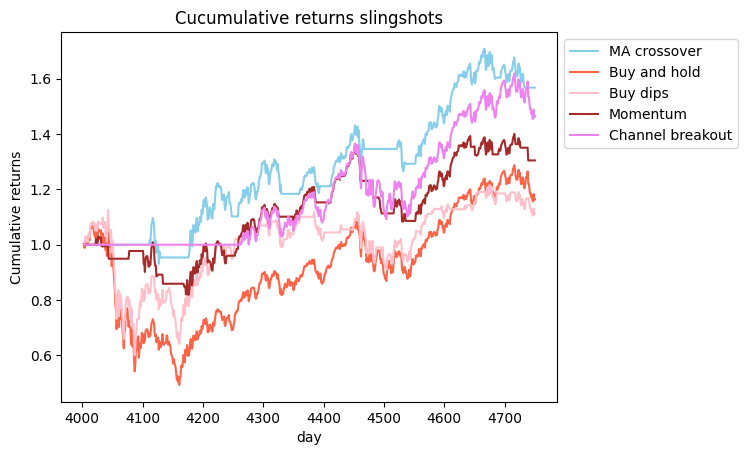

In [15]:
# Zooming in on a couple of strategies (using last three years of time series)
series = 'slingshots'

# Interval for final test set
start = results_MA.loc[results_MA['series'] == series, 'test_start'].iloc[-1]
end = results_MA.loc[results_MA['series'] == series, 'test_end'].iloc[-1]

x_test = df[start:end]

def get_final_param(results, series):
    # Filter by series
    best_params = results.loc[results['series'] == series, 'best_params']

    best_params_list = best_params.tolist()

    params = best_params_list[-1] # using the final params, as these are the ones that would have been evaluated on the final test set
    return params

final_param_MA = get_final_param(results_MA,series)
final_param_MOM = get_final_param(results_MOM,series)
final_param_BD = get_final_param(results_BD,series)
final_param_CB = get_final_param(results_CB,series)

returns_MA, cum_returns_MA  = get_MA_crossover(x_test,**final_param_MA)
returns_MOM,cum_returns_MOM = get_momentum(x_test, **final_param_MOM)
returns_BD, cum_returns_BD = get_buy_the_dip(x_test,**final_param_BD)
returns_CB,cum_returns_CB = get_channel_breakout(x_test,**final_param_CB)
returns_BNH, cum_returns_BNH = get_buy_hold(x_test)

#sns.set_style('whitegrid')
sns.lineplot(data=cum_returns_MA[series], label='MA crossover',color='skyblue')
sns.lineplot(data=cum_returns_BNH[series], label='Buy and hold',color='tomato')
sns.lineplot(data=cum_returns_BD[series],label='Buy dips',color='pink')
sns.lineplot(data=cum_returns_MOM[series],label='Momentum',color='brown')
sns.lineplot(data=cum_returns_CB[series],label='Channel breakout',color='violet')
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Cumulative returns')
plt.title('Cucumulative returns '+series)
plt.show()
